# Import the necessary libraries

In [35]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


# Build the graph

In [53]:
# Load GTFS data files
stops_df = pd.read_csv("data/stops.txt")
stop_times_df = pd.read_csv("data/stop_times.txt")
trips_df = pd.read_csv("data/trips.txt")
routes_df = pd.read_csv("data/routes.txt")
transfers_df = pd.read_csv("data/transfers.txt")


# Define the range of some parts of the metro Vancouver (Vancouver, Burnaby, Richmond, Coquitlam, Surrey)
min_lat, max_lat, min_lon, max_lon = 49.1167, 49.2978, -123.2659, -122.7262

# Filter for SkyTrain and bus routes
skytrain_bus_routes_df = routes_df[routes_df['route_type'].isin([1, 3])]

# Filter stops within the specified geographic bounds
filtered_stops_df = stops_df[(stops_df['stop_lat'] >= min_lat) & (stops_df['stop_lat'] <= max_lat) &
                             (stops_df['stop_lon'] >= min_lon) & (stops_df['stop_lon'] <= max_lon)]

# Initialize a directed graph
G = nx.DiGraph()

# Add filtered stops as nodes with their details as attributes
for idx, row in filtered_stops_df.iterrows():
    G.add_node(row['stop_id'], **row.to_dict())

# Since we've filtered stops, we need to ensure that only trips between these stops are considered
# This requires filtering the stop_times_df to include only those stops present in filtered_stops_df
filtered_stop_times_df = stop_times_df[stop_times_df['stop_id'].isin(filtered_stops_df['stop_id'])]

# The code to add edges between stops would be similar to the previous explanation,
# but you should ensure that both the from_stop_id and to_stop_id are in the list of filtered stops.
# This step is skipped here for brevity, as it follows the same logic as before.

# Incorporate transfers into the graph, ensuring both stops are within the filtered list
for idx, row in transfers_df.iterrows():
    if row['transfer_type'] in [0, 1, 2] and \
       row['from_stop_id'] in filtered_stops_df['stop_id'].values and \
       row['to_stop_id'] in filtered_stops_df['stop_id'].values:
        transfer_time = row['min_transfer_time'] / 60 if pd.notnull(row['min_transfer_time']) else 5
        G.add_edge(row['from_stop_id'], row['to_stop_id'], weight=transfer_time)
        
print(len(G.nodes()))
print(len(G.edges()))

5855
4233


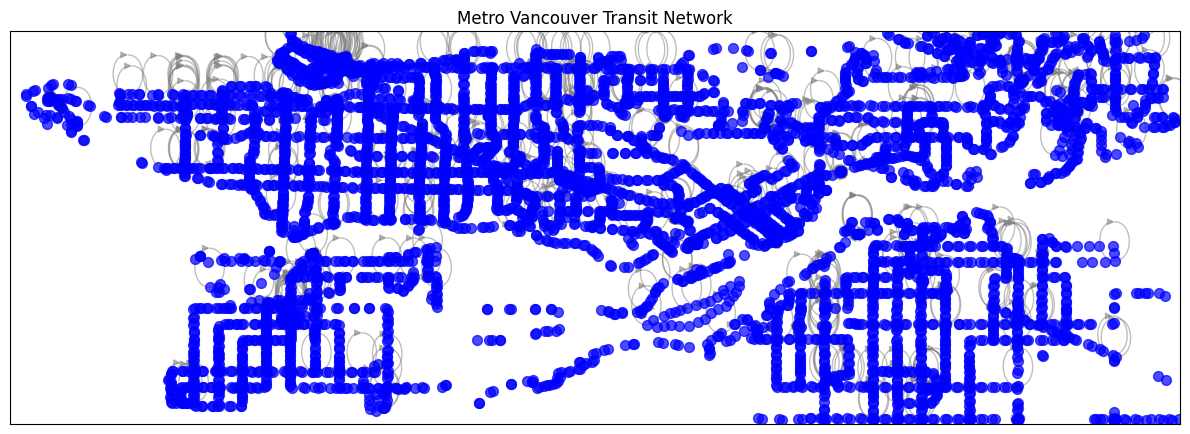

In [49]:


fig, ax = plt.subplots(figsize=(12, 12))

# Draw the nodes
pos = {node: (data['stop_lon'], data['stop_lat']) for node, data in G.nodes(data=True)}
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7, ax=ax)

# Draw the edges
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, ax=ax)


ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

ax.set_aspect('equal')

ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Metro Vancouver Transit Network')

plt.tight_layout()
plt.show()

In [45]:
print(len(G.nodes))
print(len(G.edges))

5855
4233


# Floyd-Warshall algorithm for all pairs shortest path

In [57]:
def floyd_warshall_optimized(G):
    # Get the list of nodes
    nodes = list(G.nodes())
    
    # Create a mapping of nodes to indices
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Get the number of nodes
    n = len(nodes)
    
    # Initialize the adjacency matrix with infinity
    adj_matrix = np.full((n, n), np.inf)
    
    # Fill the adjacency matrix with initial weights
    for u, v, data in G.edges(data=True):
        adj_matrix[node_to_idx[u], node_to_idx[v]] = data.get('weight', 1)
    
    # Create a copy of the adjacency matrix to store the distances
    dist = adj_matrix.copy()
    
    # Initialize the path matrix
    path = np.zeros((n, n), dtype=int)
    
    # Initialize the path matrix with the initial paths
    for i in range(n):
        for j in range(n):
            if i != j and adj_matrix[i, j] != np.inf:
                path[i, j] = i
    
    # Run Floyd-Warshall algorithm
    for k in range(n):
        i2k = dist[:, k][:, np.newaxis]
        k2j = dist[k, :][np.newaxis, :]
        i2j = dist
        
        mask = (i2k + k2j < i2j) & (i2k != np.inf) & (k2j != np.inf)
        dist[mask] = i2k[mask] + k2j[mask]
        path[mask] = path[k, :][mask]
    
    # Create a dictionary to store the shortest paths
    shortest_paths = {}
    
    # Reconstruct the shortest paths
    for i in range(n):
        for j in range(n):
            if i != j and dist[i, j] != np.inf:
                node_path = [nodes[j]]
                while path[i, j] != i:
                    j = path[i, j]
                    node_path.append(nodes[j])
                node_path.append(nodes[i])
                node_path.reverse()
                shortest_paths[(nodes[i], node_path[0])] = node_path
    
    return dist, shortest_paths

In [58]:
print(floyd_warshall(G))